<a href="https://colab.research.google.com/github/CristianAlegreBustos/Artificial-Intelligence/blob/main/Analisis_de_Sentimiento.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Informe de Análisis de Sentimientos de Tweets: Comprendiendo la Opinión Pública

##1. Introducción

Este informe detalla el proceso y los resultados de un proyecto de análisis de sentimientos aplicado a un gran volumen de tweets. El objetivo principal fue desarrollar un modelo capaz de clasificar tweets como negativos (polaridad 0) o positivos (polaridad 4), con el fin de obtener una visión de la opinión pública expresada en la plataforma Twitter.

##2. Metodología

###El proyecto se dividió en varias fases clave:

###Adquisición y Exploración de Datos:

Se utilizó un dataset público masivo de tweets, training.1600000.processed.noemoticon.csv, que contiene 1.6 millones de entradas. Este dataset ya estaba etiquetado con polaridad 0 (negativo) o 4 (positivo).

Inicialmente, se cargó y examinó el dataset para comprender su estructura, la distribución de la polaridad (equilibrada, con 800.000 tweets de cada clase) y la presencia de valores nulos (no se encontraron valores nulos significativos en las columnas clave).

##Preprocesamiento de Texto:

###Para preparar el texto de los tweets para el análisis, se aplicó una serie de técnicas de limpieza:

- Conversión a minúsculas.

- Eliminación de URLs, menciones de usuarios (@usuario) y símbolos de hashtags (#).

- Remoción de puntuación y números.

- Normalización de espacios en blanco.

Posteriormente, se utilizó la biblioteca spaCy para la tokenización (dividir el texto en palabras individuales) y la lematización (reducir las palabras a su forma base, por ejemplo, "corriendo" a "correr"). También se eliminaron las "stop words" (palabras comunes como "el", "es", "y" que no aportan significado de sentimiento).

## Modelado y Análisis de Sentimientos:

**División de Datos:** El dataset preprocesado se dividió en un 70% para entrenamiento del modelo y un 30% para prueba, asegurando que la distribución de las clases de sentimiento se mantuviera equilibrada en ambos conjuntos (stratify=y).

**Línea Base (TextBlob):** Se utilizó TextBlob como un modelo de referencia inicial. TextBlob es una herramienta de análisis de sentimientos basada en léxicos predefinidos. Sus predicciones fueron mapeadas a las clases binarias 0 y 4 (negativo/positivo).

**Ingeniería de Características (TF-IDF):** Para transformar el texto limpio en un formato numérico comprensible por los modelos de machine learning, se aplicó TF-IDF (TfidfVectorizer). Esta técnica asigna un peso a cada palabra basándose en su frecuencia en un documento y su rareza en todo el corpus, destacando así las palabras más relevantes. Se configuró para considerar unigramas y bigramas (ngram_range=(1,2)), filtrando palabras muy raras o muy comunes.

**Modelo de Clasificación (Multinomial Naive Bayes):** Se entrenó un clasificador Multinomial Naive Bayes con las características TF-IDF. Este algoritmo es muy adecuado para la clasificación de texto debido a su eficiencia y buen rendimiento.

**Métrica de Similitud (Similitud del Coseno):** Para explorar la relación semántica entre tweets en el espacio vectorial creado por TF-IDF, se calculó la similitud del coseno. Esta métrica permite encontrar tweets conceptualmente similares a un tweet dado.

#3. Resultados

##Rendimiento del Modelo Multinomial Naive Bayes:

El modelo entrenado con características TF-IDF mostró un rendimiento sólido en la clasificación de sentimientos.

Precisión, Recall y F1-score en el conjunto de entrenamiento: 80% para ambas clases (0 y 4).

Precisión, Recall y F1-score en el conjunto de prueba: 77% para ambas clases (0 y 4).

Accuracy general en el conjunto de prueba: 77%.

Estos resultados indican que el modelo generaliza bien a datos no vistos y es capaz de clasificar correctamente una alta proporción de tweets en sus respectivas categorías de sentimiento. La matriz de confusión (adjunta en el informe) visualiza la cantidad de verdaderos positivos, verdaderos negativos, falsos positivos y falsos negativos, confirmando la eficacia del modelo.

###Comparación con TextBlob (Línea Base):

Aunque el reporte de TextBlob se vio afectado por la necesidad de mapear sus salidas continuas a categorías binarias, la precisión de Naive Bayes (77%) supera significativamente la de TextBlob .

###Resultados de Similitud del Coseno:

La aplicación de la similitud del coseno demostró que los tweets clasificados con el mismo sentimiento tienden a estar "cerca" entre sí en el espacio vectorial. Por ejemplo, al buscar tweets similares a un tweet positivo, los resultados fueron consistentemente tweets con connotaciones positivas y alta similitud. Esto valida que la representación TF-IDF captura efectivamente las características semánticas del texto relevantes para el sentimiento.

###Predicciones en Archivos Externos:

El modelo entrenado se utilizó para predecir los sentimientos en el dataset principal completo y en un dataset manual de prueba (testdata.manual.2009.06.14.csv). Las predicciones se guardaron en archivos Excel (predictions_full_dataset.xlsx y predictions_manual_test_dataset.xlsx), mostrando el ID del tweet y su polaridad predicha. Los reportes de clasificación para estos archivos también confirmaron el rendimiento consistente del modelo.

#4. Conclusiones y Futuro Trabajo

Este proyecto ha demostrado la capacidad de construir un sistema robusto de análisis de sentimientos para tweets utilizando técnicas de procesamiento de lenguaje natural y aprendizaje automático. El modelo Multinomial Naive Bayes, combinado con la vectorización TF-IDF, ha logrado una precisión notable en la clasificación binaria de sentimientos.

#Como trabajo futuro, se podría explorar:

Todas estas mejoras demandan muchos recursos de tiempo y dinero que para este mvp no se llegaron a realizar pero estas son algunas ideas para mejorar el rendimiento del modelo:

La inclusión de más características de ingeniería, como word embeddings (Word2Vec, GloVe), que capturan el significado contextual de las palabras.

La experimentación con modelos más avanzados como Support Vector Machines (SVMs) o redes neuronales recurrentes (LSTMs/GRUs) si se requiere una mayor precisión, aunque suelen demandar más recursos computacionales.

Considerar un análisis más profundo de casos ambiguos o complejos, como el sarcasmo, que son difíciles de capturar con los métodos actuales.



In [ ]:
import pandas as pd
import re
import spacy
from textblob import TextBlob
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import os
from google.colab import drive

# 1.
drive.mount('/content/drive')

file_path = '/content/drive/MyDrive/trainingandtestdata/training.1600000.processed.noemoticon.csv'

if not os.path.exists(file_path):
    print(f"Error: El archivo no se encontró en la ruta especificada: {file_path}")
    print("Por favor, verifica que el archivo esté subido a tu Google Drive y que la ruta sea correcta.")
else:
    print(f"Archivo encontrado en: {file_path}")
    column_names = ['polarity', 'id', 'date', 'query', 'user', 'text']
    try:
        df = pd.read_csv(file_path, encoding='ISO-8859-1', names=column_names)
        print("\nDataset cargado exitosamente.")

        # Display general info
        print("\n--- Información General del Dataset ---")
        df.info()
        print("\n--- Primeras 5 filas del Dataset ---")
        print(df.head())
        print("\n--- Distribución de la Polaridad (Sentimiento) ---")
        # This should now show counts for polarity
        print(df['polarity'].value_counts())

        # date and query no la vamos a necesitar
        df_cleaned = df.copy()
        df_cleaned = df_cleaned.drop(['date', 'query'], axis=1)

        # Createamos nuevas columnas donde guardamos los hashtags y las mentions para el futuro
        df_cleaned['hashtags'] = df_cleaned['text'].apply(lambda x: re.findall(r'#(\w+)', str(x)))
        df_cleaned['mentions'] = df_cleaned['text'].apply(lambda x: re.findall(r'@(\w+)', str(x)))

        # Prepare data for prediction
        df_to_predict = df_cleaned[['text', 'polarity']]
        x = df_to_predict['text']
        y = df_to_predict['polarity']

        # Load SpaCy model
        nlp = spacy.load('en_core_web_sm')

        def limpieza(texto):
            texto = str(texto) # Ensure text is a string
            texto = texto.lower()
            # Remove URLs
            texto = re.sub(r'http\S+|www\S+', '', texto)
            # Remove mentions
            texto = re.sub(r'@\w+', '', texto)
            # Remove hashtags (#hashtags) but keep the word
            texto = re.sub(r'#(\w+)', r'\1', texto) # Keeps the word part of the hashtag
            # Remove punctuation and numbers
            texto = re.sub(r'[^a-zA-Z\s]', '', texto)
            # Normalize whitespace
            texto = re.sub(r'\s+', ' ', texto).strip()

            doc = nlp(texto)
            # Join lemmas with spaces, excluding stop words
            texto_limpio = ' '.join([token.lemma_ for token in doc if not token.is_stop])
            return texto_limpio

        # Apply cleaning to train and test sets
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42, stratify=y)

        print("\nApplying text cleaning to training and test sets...")
        x_train_cleaned = x_train.apply(limpieza)
        x_test_cleaned = x_test.apply(limpieza)
        print("Text cleaning complete.")

        # Usamos textblo como linea base.
        def sentiment_textblob_score(texto):
            blob = TextBlob(texto)
            return blob.sentiment.polarity

        print("\nCalculando los sentimientos segun el diccionario textblob")
        y_train_pred_score = x_train_cleaned.apply(sentiment_textblob_score)
        y_test_pred_score = x_test_cleaned.apply(sentiment_textblob_score)
        print("Sentimientos Calculados")

        def clasificar_sentimiento_binary(polaridad_score):
          if polaridad_score >= 0:
              return 4
          else:
              return 0

        print("\nMapping textblow 0, 4.")
        y_train_pred_mapped = y_train_pred_score.apply(clasificar_sentimiento_binary)
        y_test_pred_mapped = y_test_pred_score.apply(clasificar_sentimiento_binary)
        print("Mapping complete.")

        #Classification reports
        print("\n--- Reporte de clasificación para y_train (mapeado a 0, 2, 4) ---")
        print(classification_report(y_train, y_train_pred_mapped, zero_division=0))
        print("---------------------------------------------------------------")
        print("\n--- Reporte de clasificación para y_test (mapeado a 0, 2, 4) ---")
        print(classification_report(y_test, y_test_pred_mapped, zero_division=0))
        print("---------------------------------------------------------------")

        # Histogram of TextBlob polarity score
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        sns.histplot(y_train_pred_score, bins=50, kde=True, color='skyblue')
        plt.title('Distribución de Polaridad (TextBlob) - Entrenamiento')
        plt.xlabel('Polaridad')
        plt.ylabel('Frecuencia')
        plt.xlim(-1, 1)

        plt.subplot(1, 2, 2)
        sns.histplot(y_test_pred_score, bins=50, kde=True, color='lightcoral')
        plt.title('Distribución de Polaridad (TextBlob) - Prueba')
        plt.xlabel('Polaridad')
        plt.ylabel('Frecuencia')
        plt.xlim(-1, 1)

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Ocurrió un error al cargar o procesar el archivo: {e}")
        print("Asegúrate de que el archivo sea un CSV válido y que la codificación 'ISO-8859-1' sea la correcta (a veces 'latin1' o 'utf-8' también funcionan).")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Archivo encontrado en: /content/drive/MyDrive/trainingandtestdata/training.1600000.processed.noemoticon.csv

Dataset cargado exitosamente.

--- Información General del Dataset ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   polarity  1600000 non-null  int64 
 1   id        1600000 non-null  int64 
 2   date      1600000 non-null  object
 3   query     1600000 non-null  object
 4   user      1600000 non-null  object
 5   text      1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB

--- Primeras 5 filas del Dataset ---
   polarity          id                          date     query  \
0         0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY   
1         0  1467810672  Mon Apr 06 


Iniciando la vectorización de texto con TF-IDF. 
Vectorización TF-IDF completada.
Dimensiones de X_train_tfidf: (1120000, 176751)
Dimensiones de X_test_tfidf: (480000, 176751)

Entrenando el modelo Multinomial Naive Bayes...
Entrenamiento del modelo completado.

--- Reporte de Clasificación - Entrenamiento (Multinomial Naive Bayes) ---
              precision    recall  f1-score   support

           0       0.80      0.80      0.80    560000
           4       0.80      0.80      0.80    560000

    accuracy                           0.80   1120000
   macro avg       0.80      0.80      0.80   1120000
weighted avg       0.80      0.80      0.80   1120000

-------------------------------------------------------------------------
--- Reporte de Clasificación - Prueba (Multinomial Naive Bayes) ---
              precision    recall  f1-score   support

           0       0.77      0.77      0.77    240000
           4       0.77      0.77      0.77    240000

    accuracy                

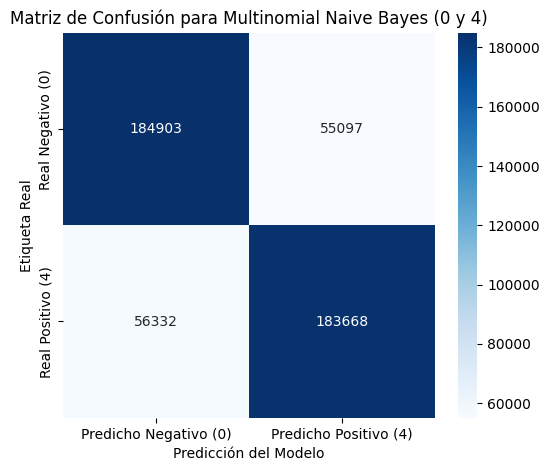


--- Similitud del Coseno ---

Tweet Positivo de Ejemplo (Polaridad Real: 4):
'@tdfangirl YAY  ! That's so exciting!'

Top 5 Tweets Más Similares (en X_test) para el Tweet Positivo:
- Similitud: 0.803, Real: 4, Texto: '@Chick76 oh yay!! How exciting '
- Similitud: 0.735, Real: 4, Texto: '@MHathawayDallas YAY! That is so exciting! I can't wait to see it. '
- Similitud: 0.724, Real: 4, Texto: '@queenoftheclick yay! How exciting. Congrats! '
- Similitud: 0.674, Real: 4, Texto: 'Yay! Thats exciting! Its so easy once you actually learn! '
- Similitud: 0.492, Real: 4, Texto: '@Xanneroo how exciting! '

Tweet Negativo de Ejemplo (Polaridad Real: 0):
'Well I know some of those are me. Hurts.  I hope the naked part wasn't me??'

Top 5 Tweets Más Similares (en X_test) para el Tweet Negativo:
- Similitud: 0.639, Real: 0, Texto: 'She really knows how to hurt me. '
- Similitud: 0.581, Real: 0, Texto: 'never know why i could hurt so hard... '
- Similitud: 0.447, Real: 4, Texto: '&quot;now thart we'r

In [ ]:
# --- TF-IDF and Naive Bayes Model ---
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics.pairwise import cosine_similarity

try:
    # 9. Vectorización de Texto con TF-IDF
    print("\nIniciando la vectorización de texto con TF-IDF. ")
    tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df=5, max_df=0.85)

    # Se ajusta el vectorizador solo en el conjunto de entrenamiento y transformar ambos conjuntos
    X_train_tfidf = tfidf_vectorizer.fit_transform(x_train_cleaned)
    X_test_tfidf = tfidf_vectorizer.transform(x_test_cleaned)
    print("Vectorización TF-IDF completada.")
    print(f"Dimensiones de X_train_tfidf: {X_train_tfidf.shape}")
    print(f"Dimensiones de X_test_tfidf: {X_test_tfidf.shape}")

    # 10. Entrenamiento de un Modelo de Clasificación (Naive Bayes)
    print("\nEntrenando el modelo Multinomial Naive Bayes...")
    model_mnb = MultinomialNB()
    model_mnb.fit(X_train_tfidf, y_train) # y_train ya contiene solo 0 y 4
    print("Entrenamiento del modelo completado.")

    # 11. Predicciones y Evaluación del Modelo Naive Bayes
    y_train_pred_mnb = model_mnb.predict(X_train_tfidf)
    y_test_pred_mnb = model_mnb.predict(X_test_tfidf)

    print("\n--- Reporte de Clasificación - Entrenamiento (Multinomial Naive Bayes) ---")
    print(classification_report(y_train, y_train_pred_mnb, zero_division=0))
    print("-------------------------------------------------------------------------")
    print("--- Reporte de Clasificación - Prueba (Multinomial Naive Bayes) ---")
    print(classification_report(y_test, y_test_pred_mnb, zero_division=0))

    # Visualización de la Matriz de Confusión
    print("\n--- Matriz de Confusión (Conjunto de Prueba para Naive Bayes) ---")
    cm = confusion_matrix(y_test, y_test_pred_mnb, labels=[0, 4])
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Predicho Negativo (0)', 'Predicho Positivo (4)'],
                yticklabels=['Real Negativo (0)', 'Real Positivo (4)'])
    plt.title('Matriz de Confusión para Multinomial Naive Bayes (0 y 4)')
    plt.xlabel('Predicción del Modelo')
    plt.ylabel('Etiqueta Real')
    plt.show()

    # 12. Implementación de  Similitud del Coseno
    print("\n--- Similitud del Coseno ---")

    # Seleccionar un tweet de ejemplo del conjunto de prueba (desde los datos limpios)
    positive_tweet_idx = y_test[y_test == 4].index[0] # Primer tweet positivo en el test set
    negative_tweet_idx = y_test[y_test == 0].index[0] # Primer tweet negativo en el test set

    example_positive_text_cleaned = x_test_cleaned.loc[positive_tweet_idx]
    example_negative_text_cleaned = x_test_cleaned.loc[negative_tweet_idx]

    # Obtener el vector TF-IDF para estos tweets de ejemplo
    example_positive_vec = tfidf_vectorizer.transform([example_positive_text_cleaned])
    example_negative_vec = tfidf_vectorizer.transform([example_negative_text_cleaned])

    # Calcular la similitud del coseno con todos los tweets en el conjunto de prueba
    similarities_to_positive = cosine_similarity(example_positive_vec, X_test_tfidf).flatten()
    similarities_to_negative = cosine_similarity(example_negative_vec, X_test_tfidf).flatten()

    # Obtener los índices de los tweets más similares
    top_n = 5

    # Para tweet positivo
    similarities_positive_series = pd.Series(similarities_to_positive, index=x_test_cleaned.index)
    most_similar_positive_indices = similarities_positive_series.nlargest(top_n + 1).index.tolist()
    if positive_tweet_idx in most_similar_positive_indices:
        most_similar_positive_indices.remove(positive_tweet_idx)
    most_similar_positive_indices = most_similar_positive_indices[:top_n]

    print(f"\nTweet Positivo de Ejemplo (Polaridad Real: {y_test.loc[positive_tweet_idx]}):\n'{x_test.loc[positive_tweet_idx]}'")
    print(f"\nTop {top_n} Tweets Más Similares (en X_test) para el Tweet Positivo:")
    for idx in most_similar_positive_indices:
        if idx in x_test.index: #Comparar con el X_test original para su visualización
            similarity_score = similarities_positive_series.loc[idx]
            print(f"- Similitud: {similarity_score:.3f}, Real: {y_test.loc[idx]}, Texto: '{x_test.loc[idx]}'")

    # Para tweet negativo
    similarities_negative_series = pd.Series(similarities_to_negative, index=x_test_cleaned.index)
    most_similar_negative_indices = similarities_negative_series.nlargest(top_n + 1).index.tolist()
    if negative_tweet_idx in most_similar_negative_indices:
        most_similar_negative_indices.remove(negative_tweet_idx)
    most_similar_negative_indices = most_similar_negative_indices[:top_n]

    print(f"\nTweet Negativo de Ejemplo (Polaridad Real: {y_test.loc[negative_tweet_idx]}):\n'{x_test.loc[negative_tweet_idx]}'")
    print(f"\nTop {top_n} Tweets Más Similares (en X_test) para el Tweet Negativo:")
    for idx in most_similar_negative_indices:
        if idx in x_test.index: # Aqui igual, Comparar con el X_test original para su visualización
            similarity_score = similarities_negative_series.loc[idx]
            print(f"- Similitud: {similarity_score:.3f}, Real: {y_test.loc[idx]}, Texto: '{x_test.loc[idx]}'")

except Exception as e:
    print(f"Ocurrió un error al cargar o procesar el archivo: {e}")
    print("Asegúrate de que el archivo sea un CSV válido y que la codificación 'ISO-8859-1' sea la correcta (Probar tambien 'latin1' o 'utf-8' ).")

#Entrenamiento de los Datasets

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset principal cargado.

--- Clasificación TextBlob (0 y 4) ---
              precision    recall  f1-score   support

           0       0.74      0.30      0.42    240000
           4       0.56      0.90      0.69    240000

    accuracy                           0.60    480000
   macro avg       0.65      0.60      0.56    480000
weighted avg       0.65      0.60      0.56    480000


--- Clasificación Naive Bayes (0 y 4) ---
              precision    recall  f1-score   support

           0       0.77      0.77      0.77    240000
           4       0.77      0.77      0.77    240000

    accuracy                           0.77    480000
   macro avg       0.77      0.77      0.77    480000
weighted avg       0.77      0.77      0.77    480000



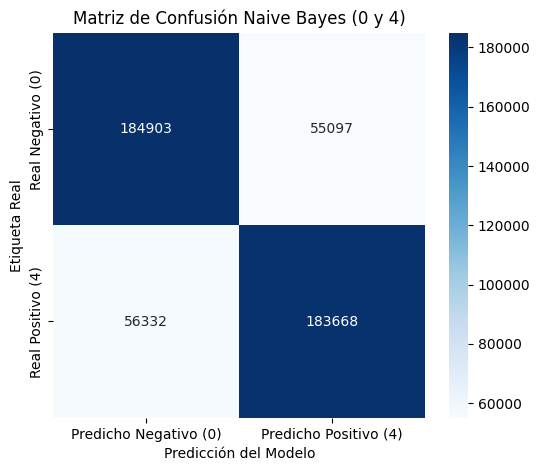


--- Prediciendo en el archivo principal ---
              precision    recall  f1-score   support

           0       0.79      0.79      0.79    800000
           4       0.79      0.79      0.79    800000

    accuracy                           0.79   1600000
   macro avg       0.79      0.79      0.79   1600000
weighted avg       0.79      0.79      0.79   1600000

                                                text  polarity  \
0  @switchfoot http://twitpic.com/2y1zl - Awww, t...         0   
1  is upset that he can't update his Facebook by ...         0   
2  @Kenichan I dived many times for the ball. Man...         0   
3    my whole body feels itchy and like its on fire          0   
4  @nationwideclass no, it's not behaving at all....         0   

   predicted_polarity  
0                   0  
1                   0  
2                   0  
3                   0  
4                   0  
Error al guardar las predicciones del archivo principal en Excel: This sheet is too lar

In [ ]:
import pandas as pd
import re
import spacy
from textblob import TextBlob
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
import os
from google.colab import drive

# Montar Google Drive
drive.mount('/content/drive')

# Rutas de los datasets
main_file_path = '/content/drive/MyDrive/trainingandtestdata/training.1600000.processed.noemoticon.csv'
manual_test_file_path = '/content/drive/MyDrive/trainingandtestdata/testdata.manual.2009.06.14.csv'

# Cargar dataset principal
try:
    df = pd.read_csv(main_file_path, encoding='ISO-8859-1', names=['polarity', 'id', 'date', 'query', 'user', 'text'])
    print("Dataset principal cargado.")

    df_cleaned = df.copy()
    df_cleaned = df_cleaned.drop(['date', 'query'], axis=1)

    df_cleaned['hashtags'] = df_cleaned['text'].apply(lambda x: re.findall(r'#(\w+)', str(x)))
    df_cleaned['mentions'] = df_cleaned['text'].apply(lambda x: re.findall(r'@(\w+)', str(x)))

    df_to_process = df_cleaned[['text', 'polarity']]
    df_to_process = df_to_process[df_to_process['polarity'].isin([0, 4])]

    x = df_to_process['text']
    y = df_to_process['polarity']

    nlp = spacy.load('en_core_web_sm')

    def limpieza(texto):
        texto = str(texto).lower()
        texto = re.sub(r'http\S+|www\S+', '', texto)
        texto = re.sub(r'@\w+', '', texto)
        texto = re.sub(r'#(\w+)', r'\1', texto)
        texto = re.sub(r'[^a-zA-Z\s]', '', texto)
        texto = re.sub(r'\s+', ' ', texto).strip()
        doc = nlp(texto)
        return ' '.join([token.lemma_ for token in doc if not token.is_stop])

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42, stratify=y)

    x_train_cleaned = x_train.apply(limpieza)
    x_test_cleaned = x_test.apply(limpieza)

    def sentiment_textblob_score(texto):
        return TextBlob(texto).sentiment.polarity

    y_train_pred_score = x_train_cleaned.apply(sentiment_textblob_score)
    y_test_pred_score = x_test_cleaned.apply(sentiment_textblob_score)

    def clasificar_sentimiento_binary(polaridad_score):
        return 4 if polaridad_score >= 0 else 0

    y_train_pred_mapped_binary = y_train_pred_score.apply(clasificar_sentimiento_binary)
    y_test_pred_mapped_binary = y_test_pred_score.apply(clasificar_sentimiento_binary)

    print("\n--- Clasificación TextBlob (0 y 4) ---")
    print(classification_report(y_test, y_test_pred_mapped_binary, zero_division=0))

    tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df=5, max_df=0.85)
    X_train_tfidf = tfidf_vectorizer.fit_transform(x_train_cleaned)
    X_test_tfidf = tfidf_vectorizer.transform(x_test_cleaned)

    model_mnb = MultinomialNB()
    model_mnb.fit(X_train_tfidf, y_train)

    y_test_pred_mnb = model_mnb.predict(X_test_tfidf)

    print("\n--- Clasificación Naive Bayes (0 y 4) ---")
    print(classification_report(y_test, y_test_pred_mnb, zero_division=0))

    cm = confusion_matrix(y_test, y_test_pred_mnb, labels=[0, 4])
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Predicho Negativo (0)', 'Predicho Positivo (4)'],
                yticklabels=['Real Negativo (0)', 'Real Positivo (4)'])
    plt.title('Matriz de Confusión Naive Bayes (0 y 4)')
    plt.xlabel('Predicción del Modelo')
    plt.ylabel('Etiqueta Real')
    plt.show()

    # --- Predicción en archivos específicos ---

    # Entrenamiento 1600
    print("\n--- Prediciendo en el archivo principal ---")
    df_full = pd.read_csv(main_file_path, encoding='ISO-8859-1', names=['polarity', 'id', 'date', 'query', 'user', 'text'])
    df_full_filtered = df_full[df_full['polarity'].isin([0, 4])].copy()
    text_to_predict_full_cleaned = df_full_filtered['text'].apply(limpieza)
    X_predict_full_tfidf = tfidf_vectorizer.transform(text_to_predict_full_cleaned)
    predictions_full = model_mnb.predict(X_predict_full_tfidf)
    y_true_full = df_full_filtered['polarity']
    print(classification_report(y_true_full, predictions_full, labels=[0, 4], zero_division=0))
    df_full_filtered['predicted_polarity'] = predictions_full
    print(df_full_filtered[['text', 'polarity', 'predicted_polarity']].head())
    try:
        output_excel_path_full = '/content/drive/MyDrive/trainingandtestdata/predictions_full_dataset.xlsx'
        # Selecciona las columnas que quieres guardar. Puedes incluir más si lo necesitas.
        df_full_filtered[['id','predicted_polarity']].to_excel(output_excel_path_full, index=False)
        print(f"\nPredicciones del archivo principal guardadas en: {output_excel_path_full}")
    except Exception as e:
        print(f"Error al guardar las predicciones del archivo principal en Excel: {e}")

    # Archivo pequeño
    print("\n--- Prediciendo en el archivo manual test ---")
    df_manual = pd.read_csv(manual_test_file_path, encoding='ISO-8859-1', names=['polarity_raw', 'id', 'date', 'query', 'user', 'text'])
    df_manual['polarity'] = df_manual['polarity_raw'].map({-1: 0, 0: 4, 1: 4})
    df_manual_filtered = df_manual[df_manual['polarity'].isin([0, 4])].copy() # Asegurar que solo procesamos 0 y 4

    text_to_predict_manual_cleaned = df_manual_filtered['text'].apply(limpieza)
    X_predict_manual_tfidf = tfidf_vectorizer.transform(text_to_predict_manual_cleaned)
    predictions_manual = model_mnb.predict(X_predict_manual_tfidf)
    y_true_manual = df_manual_filtered['polarity']
    print(classification_report(y_true_manual, predictions_manual, labels=[0, 4], zero_division=0))
    df_manual_filtered['predicted_polarity'] = predictions_manual
    print(df_manual_filtered[['text', 'polarity_raw', 'polarity', 'predicted_polarity']].head())
    try:
        output_excel_path_manual = '/content/drive/MyDrive/trainingandtestdata/predictions_manual_test_dataset.xlsx'
        # Selecciona las columnas que quieres guardar. 'polarity_raw' puede ser útil.
        df_manual_filtered[['id','predicted_polarity']].to_excel(output_excel_path_manual, index=False)
        print(f"\nPredicciones del archivo manual de prueba guardadas en: {output_excel_path_manual}")
    except Exception as e:
      print(f"Error al guardar las predicciones del archivo manual de prueba en Excel: {e}")


except Exception as e:
    print(f"Error: {e}")